Import the necessary libraries

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from numpy import genfromtxt
from sklearn import cluster

%matplotlib inline

Import CSV with tab delimiter formatting into pandas

In [2]:
df = pd.read_table('Medicare_Provider_Util_Payment_PUF_CY2015.txt', skiprows=range(1, 2))

/Users/home/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [245]:
list(df)

['npi',
 'nppes_provider_last_org_name',
 'nppes_provider_first_name',
 'nppes_provider_mi',
 'nppes_credentials',
 'nppes_provider_gender',
 'nppes_entity_code',
 'nppes_provider_street1',
 'nppes_provider_street2',
 'nppes_provider_city',
 'nppes_provider_zip',
 'nppes_provider_state',
 'nppes_provider_country',
 'provider_type',
 'medicare_participation_indicator',
 'place_of_service',
 'hcpcs_code',
 'hcpcs_description',
 'hcpcs_drug_indicator',
 'line_srvc_cnt',
 'bene_unique_cnt',
 'bene_day_srvc_cnt',
 'average_Medicare_allowed_amt',
 'average_submitted_chrg_amt',
 'average_Medicare_payment_amt',
 'average_Medicare_standard_amt']

In [246]:
df.head(5)

,npi,nppes_provider_last_org_name,nppes_provider_first_name,nppes_provider_mi,nppes_credentials,nppes_provider_gender,nppes_entity_code,nppes_provider_street1,nppes_provider_street2,nppes_provider_city,...,hcpcs_code,hcpcs_description,hcpcs_drug_indicator,line_srvc_cnt,bene_unique_cnt,bene_day_srvc_cnt,average_Medicare_allowed_amt,average_submitted_chrg_amt,average_Medicare_payment_amt,average_Medicare_standard_amt
0,1003000126,ENKESHAFI,ARDALAN,NaN,M.D.,M,I,900 SETON DR,NaN,CUMBERLAND,...,99217,Hospital observation care discharge,N,23.0,23,23,72.680000,328.000000,54.502609,55.280870
1,1003000126,ENKESHAFI,ARDALAN,NaN,M.D.,M,I,900 SETON DR,NaN,CUMBERLAND,...,99219,Hospital observation care typically 50 minutes,N,18.0,18,18,135.850000,614.000000,100.958889,102.348889
2,1003000126,ENKESHAFI,ARDALAN,NaN,M.D.,M,I,900 SETON DR,NaN,CUMBERLAND,...,99221,"Initial hospital inpatient care, typically 30 ...",N,59.0,58,59,101.365085,333.288136,79.469661,80.859831
3,1003000126,ENKESHAFI,ARDALAN,NaN,M.D.,M,I,900 SETON DR,NaN,CUMBERLAND,...,99222,"Initial hospital inpatient care, typically 50 ...",N,132.0,130,132,139.010455,356.492424,107.933409,107.969621
4,1003000126,ENKESHAFI,ARDALAN,NaN,M.D.,M,I,900 SETON DR,NaN,CUMBERLAND,...,99223,"Initial hospital inpatient care, typically 70 ...",N,220.0,215,220,205.185955,631.186364,157.908955,160.930409


In [21]:
df.groupby('provider_type').provider_type.count()

provider_type
Addiction Medicine                                 668
All Other Suppliers                                  9
Allergy/Immunology                               28468
Ambulance Service Supplier                          59
Anesthesiologist Assistants                       3784
Anesthesiology                                  227356
Audiologist (billing independently)              19130
CRNA                                            107003
Cardiac Electrophysiology                        50385
Cardiac Surgery                                  14272
Cardiology                                      458490
Certified Clinical Nurse Specialist               7190
Certified Nurse Midwife                            968
Chiropractic                                     48234
Clinical Laboratory                                902
Clinical Psychologist                            32082
Colorectal Surgery (formerly proctology)         13033
Critical Care (Intensivists)                     21

In [270]:
df = df[df['nppes_entity_code'] == 'I']
df = df[df['medicare_participation_indicator'] == 'Y']
df_rad = df.loc[df['provider_type'] == 'Diagnostic Radiology']

In [271]:
df_rad = df_rad[['nppes_provider_last_org_name','nppes_provider_first_name','nppes_provider_zip','average_Medicare_standard_amt','nppes_provider_gender','line_srvc_cnt']]

In [272]:
df_rad.head(5)

,nppes_provider_last_org_name,nppes_provider_first_name,nppes_provider_zip,average_Medicare_standard_amt,nppes_provider_gender,line_srvc_cnt
297,OWENS,JUSTIN,711102425,32.872857,M,21.0
298,OWENS,JUSTIN,711102425,7.320000,M,68.0
299,OWENS,JUSTIN,711102425,8.626713,M,143.0
300,OWENS,JUSTIN,711102425,43.240938,M,32.0
301,OWENS,JUSTIN,711102425,7.880000,M,13.0


In [273]:
outlier = df_rad['average_Medicare_standard_amt'].mean()+2*df_rad['average_Medicare_standard_amt'].std()

In [274]:
df_rad = df_rad[df_rad['average_Medicare_standard_amt'] <= outlier]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12410e208>]], dtype=object)

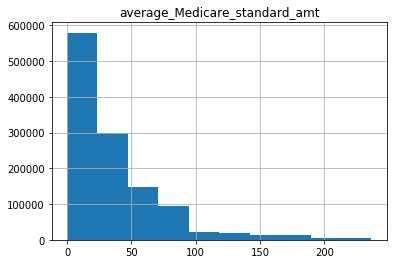

In [275]:
df_rad[['average_Medicare_standard_amt']].hist()

In [277]:
# Define a lambda function to compute the weighted mean:
wm = lambda x: np.average(x, weights=df_rad.loc[x.index, 'line_srvc_cnt'])

In [278]:
# Define a dictionary with the functions to apply for a given column:
f = {'line_srvc_cnt': ['sum'], 'average_Medicare_standard_amt': {'average_Medicare_standard_amt' : wm} }

# Groupby and aggregate with your dictionary:
df_rad = df_rad.groupby(['nppes_provider_last_org_name','nppes_provider_first_name','nppes_provider_zip','nppes_provider_gender']).agg(f).reset_index()

/Users/home/anaconda3/lib/python3.6/site-packages/pandas/core/groupby.py:4036: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


In [334]:
df_rad.groupby(['nppes_provider_gender']).count()

/Users/home/anaconda3/lib/python3.6/site-packages/pandas/core/base.py:331: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  return self.obj.drop(self.exclusions, axis=1)


,nppes_provider_last_org_name,nppes_provider_first_name,nppes_provider_zip,line_srvc_cnt,average_Medicare_standard_amt
,,,,sum,average_Medicare_standard_amt
nppes_provider_gender,,,,,
F,6577,6577,6577,6577,6577
M,22275,22275,22275,22275,22275


In [335]:
6577/22275

0.29526374859708193

In [282]:
df_rad['nppes_provider_zip'] = df_rad['nppes_provider_zip'].astype(str).str.slice(0,5)

In [283]:
df_rad.head(5)

,nppes_provider_last_org_name,nppes_provider_first_name,nppes_provider_zip,nppes_provider_gender,line_srvc_cnt,average_Medicare_standard_amt
,,,,,sum,average_Medicare_standard_amt
0,AADLAND,TIMOTHY,55905,M,2520.0,23.269175
1,AAFEDT,BRADLEY,58201,M,4644.0,14.160478
2,AAGESEN,MATTHEW,43606,M,3468.0,23.077364
3,AALBERG,JOSHUA,43202,M,2506.0,20.777466
4,AALTONEN,ERIC,10016,M,348.0,67.893822


In [284]:
temp = df_rad['nppes_provider_zip']

In [285]:
search_zip = pd.to_numeric(temp, errors='coerce')
search_zip.fillna(0, inplace=True)
temp = 0

In [290]:
zip_matching = genfromtxt('US Zip Codes from 2013 Government Data.csv', delimiter=',')
zip_matching = zip_matching[1:]
zipcode = zip_matching[:,0]

In [291]:
search_zip = search_zip.as_matrix()

AttributeError: 'numpy.ndarray' object has no attribute 'as_matrix'

In [288]:
lat_long = np.zeros((int(np.shape(search_zip)[0]),2))

In [289]:
prev_zip = 0
prev_lat = 0
prev_long = 0
loc = 0
exclude = []
for item in search_zip:
    if item == 0:
        exclude.append(loc)
        prev_lat = 0
        prev_long = 0
    elif prev_zip is not item:
        temp = np.searchsorted(zipcode, item)
        if (temp == 0) or (temp == np.size(zipcode)):
            exclude.append(loc)
        else:
            prev_lat = zip_matching[temp][1]
            prev_long = zip_matching[temp][2]
    lat_long[loc][0] = prev_lat
    lat_long[loc][1] = prev_long
    loc += 1
lat_long

array([[  44.055948,  -92.525906],
       [  47.866638,  -97.141144],
       [  41.673136,  -83.611414],
       ..., 
       [  47.645706, -117.427263],
       [  43.114542,  -77.554976],
       [  32.856347, -117.250058]])

In [295]:
temp = df_rad.as_matrix()
temp[0:4,:]

array([['AADLAND', 'TIMOTHY', '55905', 'M', 2520.0, 23.26917460320127],
       ['AAFEDT', 'BRADLEY', '58201', 'M', 4644.0, 14.160478036171364],
       ['AAGESEN', 'MATTHEW', '43606', 'M', 3468.0, 23.077364475197143],
       ['AALBERG', 'JOSHUA', '43202', 'M', 2506.0, 20.77746608146129]], dtype=object)

In [301]:
np.count_nonzero(temp[:,3]=='F')

6577

In [306]:
revenue = np.multiply(temp[:,4],temp[:,5])

In [313]:
revenue = revenue.reshape(revenue.shape[0],-1)

In [315]:
temp = np.concatenate((temp,revenue), axis = 1)

In [316]:
analysis = np.concatenate((temp,lat_long), axis = 1)

In [318]:
np.size(analysis,1)

9

In [299]:
analysis = np.delete(analysis,exclude,axis=0)

In [319]:
clustering = analysis[:,[6,7,8]]

In [320]:
sd_list = []
mean_list = []
for i in range(0,np.size(clustering,1)):
    sd = clustering[:,i].std()
    mean = clustering[:,i].mean()
    clustering[:,i] = clustering[:,i] - (np.ones(np.size(clustering,0))*mean).T
    clustering[:,i] = clustering[:,i] / sd
    sd_list.append(sd)
    mean_list.append(mean)

In [463]:
kmeans = cluster.KMeans(n_clusters=14)
kmeans.fit(clustering)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=14, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [464]:
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
dist = kmeans.inertia_

In [465]:
for i in range(0,np.size(centroids,1)):
    centroids[:,i] = centroids[:,i] * sd_list[i] + (np.ones(np.size(centroids,0))*mean_list[i]).T

In [492]:
np.around(centroids, decimals=3)

array([[  76398.142,      35.61 ,     -84.952],
       [  41699.066,      35.972,    -116.073],
       [ 371666.478,      36.167,     -86.583],
       [ 158279.378,      40.362,     -81.751],
       [  72466.539,      47.016,    -121.516],
       [  70488.758,      26.989,     -80.317],
       [  48101.339,      40.496,     -77.073],
       [ 172584.902,      36.276,    -114.636],
       [ 195041.932,      32.074,     -88.095],
       [  34628.073,      13.718,     144.94 ],
       [  58441.36 ,      31.148,     -95.776],
       [ 789602.712,      33.469,     -89.021],
       [  53840.597,      21.215,    -157.657],
       [  62976.474,      42.454,     -90.087]])

In [467]:
def count_M(data, loc, gender):
    return np.count_nonzero(data[loc] == gender)

In [468]:
diction = []
for i in range(0, np.size(centroids,0)):
    loc = np.nonzero(labels==i)[0]
    male = count_M(analysis[:,3], loc, 'M')
    female = count_M(analysis[:,3], loc, 'F')
    diction.append([male, female, female/male])

diction

[[2499, 712, 0.2849139655862345],
 [2295, 773, 0.33681917211328977],
 [574, 148, 0.2578397212543554],
 [3179, 694, 0.21830764391318025],
 [1046, 265, 0.25334608030592737],
 [937, 241, 0.25720384204909286],
 [3735, 1769, 0.47362784471218206],
 [1280, 273, 0.21328125],
 [1748, 216, 0.12356979405034325],
 [5, 2, 0.4],
 [1798, 578, 0.32146829810901],
 [78, 17, 0.21794871794871795],
 [104, 18, 0.17307692307692307],
 [2997, 871, 0.29062395729062396]]

In [469]:
loc = np.nonzero(labels==1)[0]

In [470]:
loc

array([    9,    20,    21, ..., 28824, 28842, 28851])

In [471]:
np.count_nonzero(analysis[:,3]=='F')

6577

In [472]:
lst = []
add_info = 0
for item in np.nonzero(centroids[:,0] > 100000)[0]:
    add_info = diction[item]
    add_info.append(centroids[item])
    lst.append(add_info)
    

In [473]:
lst

[[574,
  148,
  0.2578397212543554,
  array([  3.71666478e+05,   3.61673191e+01,  -8.65826864e+01])],
 [3179,
  694,
  0.21830764391318025,
  array([  1.58279378e+05,   4.03622704e+01,  -8.17506998e+01])],
 [1280,
  273,
  0.21328125,
  array([  1.72584902e+05,   3.62762241e+01,  -1.14635853e+02])],
 [1748,
  216,
  0.12356979405034325,
  array([  1.95041932e+05,   3.20741899e+01,  -8.80951333e+01])],
 [78,
  17,
  0.21794871794871795,
  array([  7.89602712e+05,   3.34694319e+01,  -8.90213361e+01])]]

In [474]:
dist

15537.462384771747

In [461]:
dist_hist.append(dist)

In [462]:
dist_hist

[63776.194547169936,
 38008.367395601708,
 29045.719216696732,
 24526.54122761777,
 21187.262906213105,
 18072.7174155791,
 15536.464688281987,
 14193.309814085947]

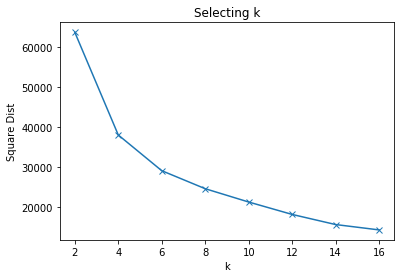

In [481]:
plt.plot(a, dist_hist, 'x-')
plt.xlabel('k')
plt.ylabel('Square Dist')
plt.title('Selecting k')
plt.show()

In [480]:
a = range(2,18,2)
len(a)

8

In [485]:
np.around([0.37, 1.64], decimals=1)

array([ 0.4,  1.6])

In [487]:
np.set_printoptions(suppress=True)